# Laboratory #5_1 : Object Detection with YOLO

At the end of this laboratory, you would get familiarized with

*   Object Detection
*   YOLO for Object Detection using Keras and TensorFlow

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# YOLOv3 for Object Detection

*   There are several open source implementations of each version of YOLO.
*   For this exercise, we would not be implementing the YOLO from scratch as it is a challenging model and requires many customized elements.
*   We would use an open source implementation of YOLOv3 available from Python Lessons github repo, implemented with TensorFlow 2.x.
*   More details about YOLO can be found [here](https://pjreddie.com/darknet/yolo/). Refer the site and also the [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) for better understanding.

## Clone the repo in the notebook

In [ ]:
# navigate to the cloned repository

%cd TensorFlow-2.x-YOLOv3/

/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3


In [ ]:
# installing additional requirements using pip

! pip install -r requirements.txt

# Please note that some libraries would return error. 
# If they are not important dependecies, you can skip those errors.
# Pip installation might require restarting the notebook. 
# Follow the installation output

## Loading pre-trained weights

*   Load the weights using any one of the methods

In [ ]:
#  download the weights to the filesystem 
# (Remember that this would not be persistent)
# If you need the weights to be persistent, upload the weights to your drive
# and load from the drive

!curl  https://pjreddie.com/media/files/yolov3.weights --output model_data/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  236M  100  236M    0     0  8472k      0  0:00:28  0:00:28 --:--:-- 10.6M0  8053k      0  0:00:30  0:00:24  0:00:06 10.1M


In [ ]:
!curl  https://pjreddie.com/media/files/yolov3-tiny.weights --output model_data/yolov3-tiny.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.7M  100 33.7M    0     0  3681k      0  0:00:09  0:00:09 --:--:-- 6250k0:00:17  0:00:06  0:00:11 2446k


## Detecting objects in images

*   Run sample predictions using the pre-trained weights

In [ ]:
from yolov3.utils import detect_image, Load_Yolo_model
from yolov3.configs import *

image_path = "./IMAGES/kite.jpg"
output_path = "./kite_pred.jpg"

yolo = Load_Yolo_model()

kite_predictions = detect_image(
    yolo, 
    image_path, 
    output_path, 
    input_size=YOLO_INPUT_SIZE, 
    show=False, 
    rectangle_colors=(255,0,0))

# You will find the predictions file saved in the output path
# all objects present in MS-COCO classes would be detected in the saved file

Loading Darknet_weights from: model_data/yolov3.weights


## Understanding Image Detection function

*   In this exercise, you have to write your own function for object detection (Each step would lead to replicating the existing function)

*   Load the input image and visualize the image using matplotlib
*   Please note that image read is different in matplotlib, skimage and opencv. You will need to do appropriate conversion if using opencv

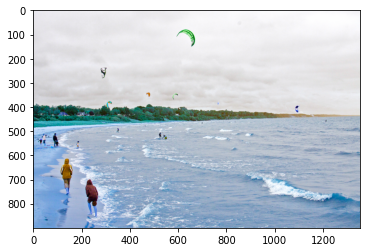

In [ ]:
# solution
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(image_path)
plt.imshow(img)


*   Load the configurations

In [ ]:
# open the configs.py file to understand the different configuration parameters

from yolov3.configs import *

*   Load the pre-trained weights using the Load_Yolo_model fuction available in yolov3.utils

In [ ]:
from yolov3.utils import Load_Yolo_model

yolo = Load_Yolo_model()

Loading Darknet_weights from: model_data/yolov3.weights


*   Preprocess the image according to the network to be used

In [ ]:
import numpy as np
from yolov3.utils import image_preprocess

image_data = image_preprocess(np.copy(img), [YOLO_INPUT_SIZE, YOLO_INPUT_SIZE])
image_data = image_data[np.newaxis, ...].astype(np.float32)

print('Original image:', img.shape)
print('Processed image:', image_data.shape)

Original image: (900, 1352, 3)
Processed image: (1, 416, 416, 3)


### Prediction boxes

*   Predict bounding boxes using the predict method 

In [ ]:
pred_bbox = yolo.predict(image_data)

*   Get the prediction statistics

In [ ]:
print('Length of the prediction boxes =', len(pred_bbox))
print('Shape of each prediction box ')

for i in range(len(pred_bbox)):
    print('Shape of prediction box', i, 'is', pred_bbox[i].shape)

Length of the prediction boxes = 3
Shape of each prediction box 
Shape of prediction box 0 is (1, 52, 52, 3, 85)
Shape of prediction box 1 is (1, 26, 26, 3, 85)
Shape of prediction box 2 is (1, 13, 13, 3, 85)


*   Why is the length of prediction boxes 3?

**Solution**

The length of the bounding boxes indicate a couple of things: 

1. it was defined in the config.py file 
2. We can see that from the paper, they define S=7, B=2, this gives rise to 7x7x2 = 98. 
3. Now from those bounding boxes there is going to be a threshold value which is going to be responsible for discarding the boxes with a low value. This is a value that can be set manually. 
4. Lastly, there is the IOU score (Intersection over Union) which is used to identify and discard the overlapping boxes. 

*   What does the shape of each prediction box represent?
*   Which layer corresponds to each prediction box output?

**Solution**

1) The shape of the prediction box represent the confidence to which it surrounds the detected objects. As in, the shape is corresponding to the type of object we want to detect (tall, slim, or big and wide).

2) Fc layers on top of the CNN feature extractor. 

*   What does 85 represent in the last dimension of the prediction box shape?

**Solution**

Number of output channels corresponding to: 

$$B \cdot (5 + C) $$

Which is defined in the YOLO paper, under the dimension section

*   What is the aim in having three prediction boxes array?
*   Why is it helpful?

**Solution**

The aim of having N different prediction box arrays is to identify the different objects we will have in our image or video. Since in one of the first steps of YOLO, it separates the image into S x S grids, where there can be N different prediction boxes. These are later on filtered out to find the best one. Basically, we are giving YOLO different shapes so that it can fit the objects into those shapes. Since this is the interesting part of YOLO, it will predict the bounding boxes w.r.t. the anchor boxes which will be discussed below. 


At the same time "YOLOv3 predicts boxes at 3 different scales." this means that it uses the prediction boxes array in order to predict at the different scales. (Source: YOLOv3 Paper)

This is helpful because: 
- Does not map the boxes onto the entire image size but rather onto the seggregated S x S grid done in one of the first steps. 
- And these boxes will then be filtered out if they have a low score, or too much of an overlap

*   Reshape the prediction boxes

In [ ]:
import tensorflow as tf

pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)

print(pred_bbox.shape)

(10647, 85)


*   What do you think happens in the previous cell (reshaping the prediction boxes)? Explain the code as per your understanding.
*   Why do you think this step is needed?

**Solution**

tf.reshape returns a new tensor with a new shape, in this case the parameter "shape" is equal to tf.shape(x)[-1], which means we will be taking the last value of the tensor which is the number of columns. From the documentation we can see that using the value -1 we can keep the tensor constant, such that we flatten it in 1D. 


=> Basically we are doing a np.squeeze on the initial three dimensions, we take:

[a, b, c, d, e] --> [b * c * d, e] 

Which is similar to a einsum(qhjk --> qhj,k)

This step is needed because when the grid is divided into S x S, there will be several bounding boxes wrt to the anchor boxes. I think that it will also help in generating the anchor boxes which is done via a K-means clustering of the actual bounding boxes. In this sense, we are "compressing" the dimensions such that it can be passed onto the next layer of the model without issues. 



*   What are anchor boxes? What is the significance of anchor boxes in YOLO?

**Solution**

The anchor boxes are what YOLO predicts for the given objects. These anchor boxes are a list of predefined shapes which best match the desired objects. 

YOLO predicts the shape of bounding boxes w.r.t the anchor boxes. More precisely, yolo predicts:

- offset of the box center (tx and ty in the figure below, need to pass through a sigmoid func) to the top left corner of a grid
- the width and height of the box w.r.t an anchor box (tw and th in the figure below. pw and ph are the size of the anchor)
- The coordinates of a box is (bx, by, bw, bh), all w.r.t to the size of the grid. To convert it to full-image scale, multiply by 32 and offset by the central coordinates 

*   Post process the prediction bounding boxes

In [ ]:
from yolov3.utils import postprocess_boxes

score_threshold = 0.3

bboxes = postprocess_boxes(pred_bbox, img, YOLO_INPUT_SIZE, score_threshold)

*   What is score threshold? What is the role of score threshold?

**Solution**
The score threshold is the one in control of how many bounding boxes we will see, it is a similar threshold to IOU. 

*   What happens when the score_threshold is low? What happens when it is high?

**Solution**

Low = more bounding boxes 
High = less bounding boxes 

### Non-maximum Supression

*   What is non-maximum supression? Why is it needed?
*   What happens in this step?

**Solution**

WHAT IS IT? --> 
Non-max suppression is the final step of these object detection algorithms and is used to select the most appropriate bounding box for the object. 


WHY WE NEED IT? --> Because it selects the best bounding box for the given object. Given N bounding boxes in a S x S grid, it will reduce the number of bounding boxes such that N==1, and we are left with one bounding box that is best fit for this. 


WHAT HAPPENS? --> In this case it calculates which bounding box fits the best for the given object. It takes into account two sepparate things: 
1. objectiveness score, which is given by YOLO, it tells you how certain a model is that the object is in this region. 
2. IOU, it will first select the bounding box with the highest objectiveness score, and then remove the boxes with the highest overalp. Thus keeping the best bounding box for the given object in the defined grid. 

*   Apply NMS on the bounding boxes.

In [ ]:
from yolov3.utils import nms

iou_threshold = 0.45

bboxes1 = nms(bboxes, iou_threshold, method='nms')
len(bboxes1)

rng = np.arange(0,1,0.05)
for i in rng:
    bboxes_n = nms(bboxes, i, method='nms')
    print(i, len(bboxes_n))

0.0 2
0.05 15
0.1 15
0.15000000000000002 15
0.2 15
0.25 15
0.30000000000000004 15
0.35000000000000003 15
0.4 15
0.45 15
0.5 15
0.55 15
0.6000000000000001 16
0.65 16
0.7000000000000001 17
0.75 18
0.8 18
0.8500000000000001 19
0.9 20
0.9500000000000001 20


*   What is the role of IoU Threshold? What happens when a IoU higher threshold is used?

**Solution**

The IOU threshold gives you the Intersect over the Union. Initially, it is an evaluation metric to see how well the model is able to draw the bounding boxes around the given object that needs to be detected. If we increase or decrease the value, it will keep different bounding boxes. This means that if we increase the IoU threshold, we are going to end up with more bounding boxes!

In [ ]:
#  draw the predicted bounding boxes on the image

from yolov3.utils import draw_bbox

pred_image = draw_bbox(img, bboxes, CLASSES=YOLO_COCO_CLASSES, rectangle_colors='')

### Predicting output

*   Visualize the pred_image using matplotlib

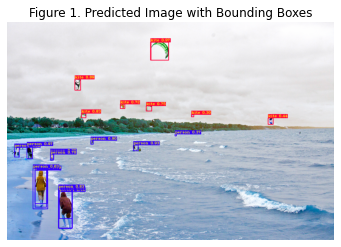

In [ ]:
# solution

plt.imshow(pred_image)
plt.title('Figure 1. Predicted Image with Bounding Boxes')
plt.axis('off')
plt.show()

# YOLO training

*   In this exercise, the task is to train mnist dataset using YOLOv3-Tiny model
*   Load the YOLOv3-Tiny weights using any one of the methods
*   For this experiment, we would use MNIST as the training data
*   Please note that all the necessary code is already available in the repo

In [ ]:
# download the weights to the filesystem 
# (Remember that this would not be persistent)

! wget -P model_data https://pjreddie.com/media/files/yolov3-tiny.weights

### Prepare data

*   The model takes a long time to train even with GPU. In order to fasten the training process, let us change the number of training and testing images in **mnist/make_data.py** file.
```
images_num_train = 500  # line number 20 in make_data.py
images_num_test = 50  # line number 21 in make_data.py
```
*   PS: 
    *   The dataset is already available in the repository.
    *   The file can be opened by double clicking on the filename from the Files menu.


*   Prepare the dataset for training

In [ ]:
! python mnist/make_data.py

### Tensorboard Visualization

*   Tensorboard is a visualization toolkit that allows for tracking and visualizing metrics such as loss and accuracy.
*   We would get introduced to tensorboard visualization here.
*   More information can be seen [here](https://www.tensorflow.org/tensorboard)

In [ ]:
# Load the TensorBoard notebook extension

%load_ext tensorboard

### Train the network

*   Change the following train options in the **configs.py** file in the yolov3 folder
```
TRAIN_YOLO_TINY = True
# Replace the batch size with smaller number if the GPU size is not sufficient 
TRAIN_BATCH_SIZE = 128
# Replace the train epochs with smaller number for faster training
TRAIN_EPOCHS = 50
```



*   Train the model using MNIST dataset

In [ ]:
! python ./mnist/make_data.py

=> /Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000001.jpg 333,241,355,263,4 155,271,177,293,7 279,111,307,139,7 226,92,268,134,9 171,146,213,188,2 192,191,248,247,9 245,349,287,391,4 71,163,155,247,8 61,38,145,122,0 284,7,396,119,9
=> /Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000002.jpg 208,302,230,324,6 191,352,213,374,4 365,115,379,129,9
=> /Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000003.jpg 138,250,160,272,7 79,141,93,155,3 288,84,310,106,1 291,270,347,326,4 1,69,85,153,1 166,179,278,291,2
=> /Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000004.jpg 194,392,216,414,7 395,333,409,347,5 334,253,362,281,3 53,173,81,201,2 355,95,397,137,9 348,354,404,410,2
=> /Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/mnist/mnist_train/000005.

In [ ]:
! python train.py

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 254981068176241276
xla_global_id: -1
]
GPUs []
skipping conv2d_12
skipping conv2d_9
Traceback (most recent call last):
  File "/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/train.py", line 188, in <module>
    main()
  File "/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/train.py", line 139, in main
    for image_data, target in trainset:
  File "/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/yolov3/dataset.py", line 133, in __next__
    label_mbbox, label_lbbox, mbboxes, lbboxes = self.preprocess_true_boxes(bboxes)
  File "/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/yolov3/dataset.py", line 268, in preprocess_true_boxes
    anchors_xywh[:, 2:4] = self.anchors[i]
ValueError: could not broadcast input array from shape (3,2) into shape (5,2)


*   If your tensorboard does not load, try to follow the following gif.

![](https://i.stack.imgur.com/ENl6b.gif)

In [ ]:
# Visualize the training curves
# you can find the different loss curves by selecting custom scalars option
# in the top right drop down

#%tensorboard --logdir /content/TensorFlow-2.x-YOLOv3/log/

'''
I had to use it locally because I consumed all my GPU hours on multiple accounts with GoogleColab


'''

'\nI had to use it locally because I consumed all my GPU hours on multiple accounts with GoogleColab\n\n\n'

*   Explain the loss used in YOLOv3

**Solution**

The loss function for YOLO can be described with three different components: 

1. Localization Loss 
2. Classification Loss 
3. Confidence Loss 

In order to measure these we need the following: 
- Features 
- Labels 
- Anchors 
- Hyperparameters

**Localization Loss** 
- Measures the quality of the predicted bbox location and size
    - Measures the distance between the predicted box center and the ground truth center
    - Difference in box sizes and shapes 

**Classification Loss**
- Measure the quality of the object classification 
    - For every grid and every anchor channel that contains a ground truth box, we calculate the probabilisitic difference. 

**Confidence Loss**
- Measures the sensitivity of detection (TP/TN/FP/FN)
    - Measuring the ground truth C, by measuring the IOU of boxes and anchors. 
    - Difference between Ci and Ci_predicted 

### Predicting objects

*   Change the following option in the **detect_mnist.py** 
```
ID = random.randint(0, 50)  # depending on the number of images in test set
```
*   Change the following train options in the **configs.py** 
```
TRAIN_MODEL_NAME = f"{YOLO_TYPE}_custom_Tiny"
```

*   Run the detction script to find the outut

In [ ]:
! python detect_mnist.py

# You will find the predictions file saved in the output path

Traceback (most recent call last):
  File "/Users/Eric/Documents/Uni/Msc/Courses/Sem1/CV/LAB/p5_1_YOLO/TensorFlow-2.x-YOLOv3/detect_mnist.py", line 30, in <module>
    yolo.load_weights(f"./checkpoints/{TRAIN_MODEL_NAME}") # use keras weights
  File "/Users/Eric/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/Eric/venv/lib/python3.9/site-packages/tensorflow/python/training/py_checkpoint_reader.py", line 35, in error_translator
    raise errors_impl.NotFoundError(None, None, error_message)
tensorflow.python.framework.errors_impl.NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./checkpoints/yolov3_custom


# Understanding Object Detection

*   What is the latest YOLO version available in literature? From the initial versions to the current version, what differences are made in each version?

**Solution**

Current Version: YOLOv5

YOLO: bounding boxes and identifying class labels in an end-to-end fashion. However, it is a single stage detector (SSD), which means it handles object identification and classification in a single pass of the network. 

YOLOv2: Changed architecture, higher resolution of images, anchor boxes and addition of BatchNormalization layer in their network. 

YOLOv3: Added objectness to bounding boxes, added residuals to the backbone network layer (similar to ResNet), made predictions at the different level of granularity. 

YOLOv4: (without Joseph Redmon, is it really YOLO without him?) improved feature aggregation, mish activation. Real-time detection is its priority, training on a single GPU. Backbone based on DenseNet (vanishing gradient is kind of solved by this), feature propagation (connectedness of the residuals),"bag of freebies" (MixUp, CutMix, Crop/Rotation/Flip/Hue/Staruation/Exposure/Aspect, Mosaic, Blur). In addition to SAT (Self-adversarial Training). And many more additions such as their CIoU loss, Bag of Specials (various activation functions such as Mish activation function), DIoU NMS, Cross mini-Batch Normalization, DropBlock Regularization. 

SAT --> finds the portion of the image that the network most relies on during training, then edits the image to "hide" this portion, forcing the network to generalize with new features. 


YOLOv5: no paper. Mosaic augmentation. 5 different model sizes. Initially written in pytorch! Decreased model size, increased performance. Basically taking all the good things from the previous models, adapting it to pytorch and optimizing it. 

*   What are the other object detection frameworks available in the literature? 
*   How different are they compared with YOLO?

**Solution**
Apart from YOLO we can find: 
- EfficientDet 
- ATSS
- ASFF
- CenterMask


The difference is that most of these are not SSD, but require multiple passes through the network. YOLO, on the other hand is able to do this in a single-shot detection(SSD). 


*    What is the underlying algorithm behind YOLO? Explain each stage briefly.

**Solution**

Employs a CNN to detect object in real-time. And it only requires a single forward propagation through the NN to detect the objects. 

What does the alg contain: 
- Residiual blocks 
    - Divide the image into various grids (S x S)
- Bounding box regression 
    - Bounding box outlines the object that is being detected wrt to the ground truth. 
    - used to predict the class, height, width and center of the objet. 
- Intersection Over Union 
    - How the boxes overlap. Which boxes? The Anchor boxes (ground truth) against the bounding boxes (predicted). With this we can measure how efficient it is and in addition to the objectness score, it will reduce the number of bounding boxes and keep the most "accurate" or best fit one. 

*   Explain the network architecture used in training YOLO

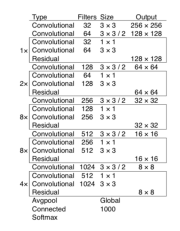

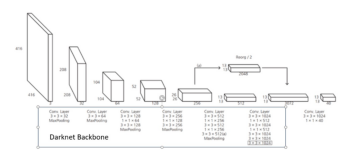

In [ ]:
import matplotlib.pyplot as plt
img1 = '/Users/Eric/desktop/yolo_layout.png'
img2 = '/Users/Eric/desktop/yolo_architecture.png'

plt.imshow(plt.imread(img1))
plt.axis('off')
plt.show()

plt.imshow(plt.imread(img2))
plt.axis('off')
plt.show()

The images above show the architecture and the layout of the model, we can see that. It uses a Darknet53 backbone which means that there are 53 convolutional layers. Since the convolutions usually downsample an image, the model also upscales the image with a 2x, in order to preserve feature integrity. Additionally, there are residiual connections which allow for more fine-grained granulairty of the the features, reducing the vanishing gradient and information leak throughout the network. 

*   What are the drawbacks in object detection frameworks?

**Solution**

- Speed of real-time detection 
- Object classification and localization 
- Limited data
- Class imbalance
- High detection precision, low misdetection rate 
- Shape of the bounding box localizing the object 
- Poor result with small objects, easy to mislocate 
- Large model calculations 
- Affected by artificial factors 
- Complex models / architectures


---

# **End of P5_1: Object Detection with YOLO**
Deadline for P5_1 submission in CampusVirtual is: **Monday, the 20th of December, 2021**